In [44]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper,BravyiKitaevMapper
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import spsa

In [2]:
n = 2
N = 2*n
t=1
mu=1.5
U=3

In [3]:
op = FermionicOp(
    {
        "+_0 -_0": 1.0,
        "+_1 -_1": -1.0,
    },
    num_spin_orbitals=2,
)

In [4]:
print(op)

Fermionic Operator
number spin orbitals=2, number terms=2
  1.0 * ( +_0 -_0 )
+ -1.0 * ( +_1 -_1 )


In [5]:
def qOp(i,j):
    return FermionicOp(
    {
        "+_{i} -_{j}".format(i=i%N,j=j%N): 1.0,
    },
    num_spin_orbitals=N,
)

In [6]:
t_list = []
U_list = []
for i in range(n):
    t_list.append((2*i,(2*i+2)%N))
    t_list.append((2*i+1,(2*i+3)%N))
site_list = [2*i for i in range(n)]

t_term = 0
U_term = 0
mu_term = 0

for edge in t_list:
    t_term += qOp(edge[0],edge[1])
    t_term += qOp(edge[1],edge[0])

for u in site_list:
    mu_term += qOp(u,u) + qOp(u+1,u+1)
    U_term += qOp(u,u)@qOp(u+1,u+1)

H = U * U_term - mu * mu_term - t * t_term

print(H)

U_list = [(i,i+1) for i in site_list]

Fermionic Operator
number spin orbitals=4, number terms=10
  3.0 * ( +_0 -_0 +_1 -_1 )
+ 3.0 * ( +_2 -_2 +_3 -_3 )
+ -1.5 * ( +_2 -_2 )
+ -1.5 * ( +_3 -_3 )
+ -1.5 * ( +_1 -_1 )
+ -1.5 * ( +_0 -_0 )
+ -2.0 * ( +_1 -_3 )
+ -2.0 * ( +_2 -_0 )
+ -2.0 * ( +_0 -_2 )
+ -2.0 * ( +_3 -_1 )


In [7]:
mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(H)
print(qubit_jw_op)

SparsePauliOp(['IIII', 'IIZZ', 'ZZII', 'YZYI', 'XZXI', 'IXZX', 'IYZY'],
              coeffs=[-1.5 +0.j,  0.75+0.j,  0.75+0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,
 -1.  +0.j])


In [13]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(N)

In [10]:
from qiskit.providers.fake_provider import GenericBackendV2

# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = GenericBackendV2(num_qubits=N)
print(backend)

In [57]:
#cost dict
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
#cost func
def cost_func(params, ansatz, hamiltonian, estimator):
    
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [58]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2


class VQE:

    def __init__(self,backend,ansatz, cost_f, optimizer = "cobyla",estimator = None,shots = 1024):
        #backend
        self.backend = backend
        #transpiled ansatz
        self.num_params = ansatz.num_parameters
        target = backend.target
        pm = generate_preset_pass_manager(target=target, optimization_level=3)
        self.ansatz = pm.run(ansatz)
        #optimizer
        self.optimizer = optimizer
        #estimator
        if estimator is not None:
            self.estimator = estimator
        else:
            estimator = BackendEstimatorV2(backend=backend)
            estimator.options.default_shots = shots
            self.estimator = estimator
        #cost
        self.cost_f = cost_f



    def compute_minimum_eigenvalue(self,hamiltonian,x0 = None,aux_operators = []):
        #hamiltonian
        hamiltonian_isa = hamiltonian.apply_layout(layout=self.ansatz.layout)
        for i,op in enumerate(aux_operators):
            aux_operators[i] = op.apply_layout(layout=self.ansatz.layout)
        if x0 is None:
            x0 = 2 * np.pi * np.random.random(self.num_params)
        res = minimize(
        self.cost_f,
        x0,
        args=(self.ansatz, hamiltonian_isa, self.estimator),
        method=self.optimizer,
        )
        
        return res


In [59]:
vqe = VQE(backend,ansatz,cost_func,optimizer='cobyla')

In [60]:
res = vqe.compute_minimum_eigenvalue(hamiltonian = qubit_jw_op)

Iters. done: 1 [Current cost: -2.076171875]
Iters. done: 2 [Current cost: -2.28466796875]
Iters. done: 3 [Current cost: -1.57568359375]
Iters. done: 4 [Current cost: -1.4940185546875]
Iters. done: 5 [Current cost: -2.670654296875]
Iters. done: 6 [Current cost: -2.7457275390625]
Iters. done: 7 [Current cost: -2.6934814453125]
Iters. done: 8 [Current cost: -2.518310546875]
Iters. done: 9 [Current cost: -2.438720703125]
Iters. done: 10 [Current cost: -3.3634033203125]
Iters. done: 11 [Current cost: -2.688720703125]
Iters. done: 12 [Current cost: -2.62646484375]
Iters. done: 13 [Current cost: -3.667236328125]
Iters. done: 14 [Current cost: -3.6201171875]
Iters. done: 15 [Current cost: -3.402099609375]
Iters. done: 16 [Current cost: -3.1666259765625]
Iters. done: 17 [Current cost: -3.193115234375]
Iters. done: 18 [Current cost: -2.83740234375]
Iters. done: 19 [Current cost: -3.2799072265625]
Iters. done: 20 [Current cost: -3.0291748046875]
Iters. done: 21 [Current cost: -3.8828125]
Iters. d

In [61]:
import scipy.sparse as sp

ham_mat = qubit_jw_op.to_matrix(sparse = True)
eig = np.real(sp.linalg.eigs(ham_mat,k=1,return_eigenvectors=False))
print(eig)

[-5.77200187]


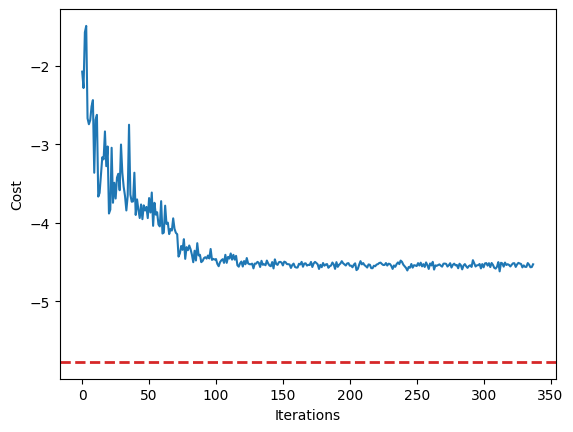

In [62]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=eig, color="tab:red", ls="--", lw=2, label="Target: " + str(eig))
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [77]:
from qiskit.circuit.library import SwapGate
from scipy.linalg import expm
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import EvolvedOperatorAnsatz, PauliEvolutionGate, HamiltonianGate

#eZZ gate
theta = 0.7809
Smat = SwapGate().to_matrix()
Sop = Operator(SwapGate())
#print(Sop)
#expS = expm(1j*Smat)
#def expSt(t):
#    return np.power(expS,t)

def eSwap(circ,i,j,param):
    eSt = HamiltonianGate(Sop,param,label = "eSWAP")
    circ.append(eSt,[i,j])


def eZZ(circ,i,j,t):
    circ.cx(i,j)
    circ.rz(t,j)
    circ.cx(i,j)

def fij(circ,i,j,t):
    eSwap(circ,i,j,t)
    circ.cp(t,i,j)

def efSwap(circ,i,j,t):
    for k in range(j-1,i,-1):
        circ.cz(j,k)
    fij(circ,i,j,t)
    for k in range(i+1,j,1):
        circ.cz(j,k)

def hopping(circ,r):
    n = circ.num_qubits
    t_s = ParameterVector("t_h{r}".format(r=r),length = n)
    for i in range(n):
        efSwap(circ,i,(i+2)%n,t_s[i])

def interaction(circ,r):
    n = circ.num_qubits
    t_s = ParameterVector("t_i{r}".format(r=r),length = n//2)
    for i in range(0,n,2):
        eZZ(circ,i,i+1,t_s[i//2])


li = [i for i in range(0,n,4)]+[i+1 for i in range(0,n,4)]
def start(circ):
    n = circ.num_qubits
    for i in li:
        circ.x(i)
        circ.h(i+2)
        circ.cx(i,i+2)
    circ.barrier()

def start2(circ):
    n = circ.num_qubits
    li = [i for i in range(0,n//2,2)]+[n-1-i for i in range(0,n//2,2)]
    circ.x(li)
    circ.barrier()

def hopint(circ,reps = 3):
    for r in range(reps):
        hopping(circ,r)
        interaction(circ,r)

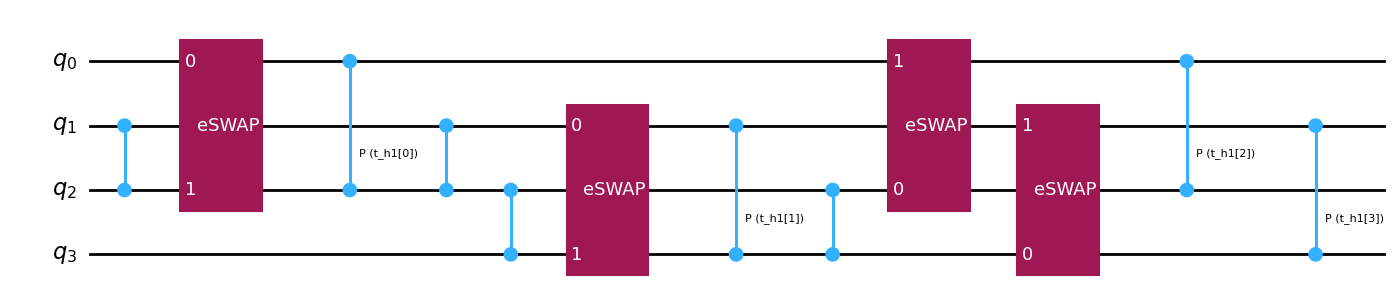

In [78]:
circ = QuantumCircuit(N)
hopping(circ,1)
circ.draw(output="mpl", style="iqp")

In [ ]:
ans_hop = QuantumCircuit(N)
